In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import set_config
set_config(display='diagram')

clustering_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/option_A_clustering_df - option_A_clustering_df.csv')
df = clustering_df.copy()
df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,1,50,0,220,0,6,0,2,1,1965,-122.196399,47.336118
1,474250,1390,0,0,0,2200,810,810,0,0,1,0,0,340,0,4,1,0,1,1945,-122.361913,47.509874
2,667950,1010,0,1515,0,2525,0,0,0,400,0,167,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3,659000,660,0,540,0,1820,620,620,0,0,1,0,0,100,0,3,1,0,2,2016,-122.370252,47.565146
4,656500,2310,0,0,0,2310,0,0,0,440,0,40,0,320,0,3,0,0,2,1967,-122.184194,47.730389


In [ ]:
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [ ]:
#Remove duplicates
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

29
0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4915 entries, 0 to 4943
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SalePrice           4915 non-null   int64  
 1   SqFt1stFloor        4915 non-null   int64  
 2   SqFtHalfFloor       4915 non-null   int64  
 3   SqFt2ndFloor        4915 non-null   int64  
 4   SqFtUpperFloor      4915 non-null   int64  
 5   SqFtTotLiving       4915 non-null   int64  
 6   SqFtTotBasement     4915 non-null   int64  
 7   SqFtFinBasement     4915 non-null   int64  
 8   SqFtGarageBasement  4915 non-null   int64  
 9   SqFtGarageAttached  4915 non-null   int64  
 10  DaylightBasement    4915 non-null   int64  
 11  SqFtOpenPorch       4915 non-null   int64  
 12  SqFtEnclosedPorch   4915 non-null   int64  
 13  SqFtDeck            4915 non-null   int64  
 14  BrickStone          4915 non-null   int64  
 15  Bedrooms            4915 non-null   int64  
 16  BathHa

No missing values in the dataset, and all dtypes are numeric! 

In [ ]:
df.describe()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
count,4.915000e+03,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,6.645444e+05,1179.083418,51.959919,347.439064,26.524517,1937.448627,596.627874,334.984334,102.333672,170.879959,0.373143,55.402035,8.236623,148.607121,4.441913,3.379451,0.387792,0.627263,1.320244,1971.915768,-122.271623,47.572308
std,2.985774e+05,444.925946,174.811762,544.865685,114.672475,765.663840,567.978214,423.696071,187.330438,239.934554,0.483689,95.997155,37.495879,201.620800,18.695589,0.945969,0.506142,0.652341,0.610240,32.816671,0.086500,0.127344
min,6.000000e+04,260.000000,0.000000,0.000000,0.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,-122.526072,47.213547
25%,4.500000e+05,880.000000,0.000000,0.000000,0.000000,1390.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1952.000000,-122.346012,47.488558
50%,6.300000e+05,1170.000000,0.000000,0.000000,0.000000,1770.000000,560.000000,110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,3.000000,0.000000,1.000000,1.000000,1966.000000,-122.291694,47.576855
75%,7.899500e+05,1450.000000,0.000000,580.000000,0.000000,2370.000000,1070.000000,570.000000,190.000000,400.000000,1.000000,80.000000,0.000000,250.000000,0.000000,4.000000,1.000000,1.000000,2.000000,2015.000000,-122.192353,47.680911
max,1.998000e+06,3600.000000,2000.000000,3010.000000,1220.000000,6695.000000,3070.000000,2620.000000,1090.000000,1830.000000,1.000000,1060.000000,620.000000,1940.000000,100.000000,8.000000,3.000000,4.000000,5.000000,2019.000000,-122.090088,47.777422


1) The zero values for a number of columns make sense as some houses may not have a 2nd floor, basement, etc. 

2) The Latitude and Longitude values are very similar, which makes sense since the homes are all in King County.

In [ ]:
print(df['Bedrooms'].value_counts())
print(df['BathFullCount'].value_counts())

3    2204
4    1467
2     637
5     465
6      62
1      52
7      13
0      13
8       2
Name: Bedrooms, dtype: int64
1    3345
2    1248
3     184
0     115
4      19
5       4
Name: BathFullCount, dtype: int64


In [ ]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

It seems odd that some houses have no Bedrooms and Bathrooms but there are only a handful of houses like that. 



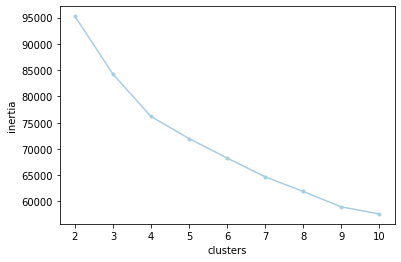

In [ ]:
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)  
    kmeans.fit(scaled_df)  
    inertias.append(kmeans.inertia_)
    
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia');

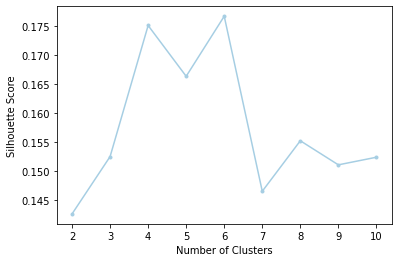

In [ ]:
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_df)
  silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))
  
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

Based on the two graphs above, I would chose a K of 4 or 5. 

The elbow in the inertia graph is at 4. However, a K of 5 has a higher Silhouette score so I will drilldown to determine which to pick. 

In [ ]:
km = KMeans(n_clusters = 4, random_state=42)
km.fit(scaled_df)
km2 = KMeans(n_clusters = 5, random_state=42)
km2.fit(scaled_df)

KMeans(n_clusters=5, random_state=42)

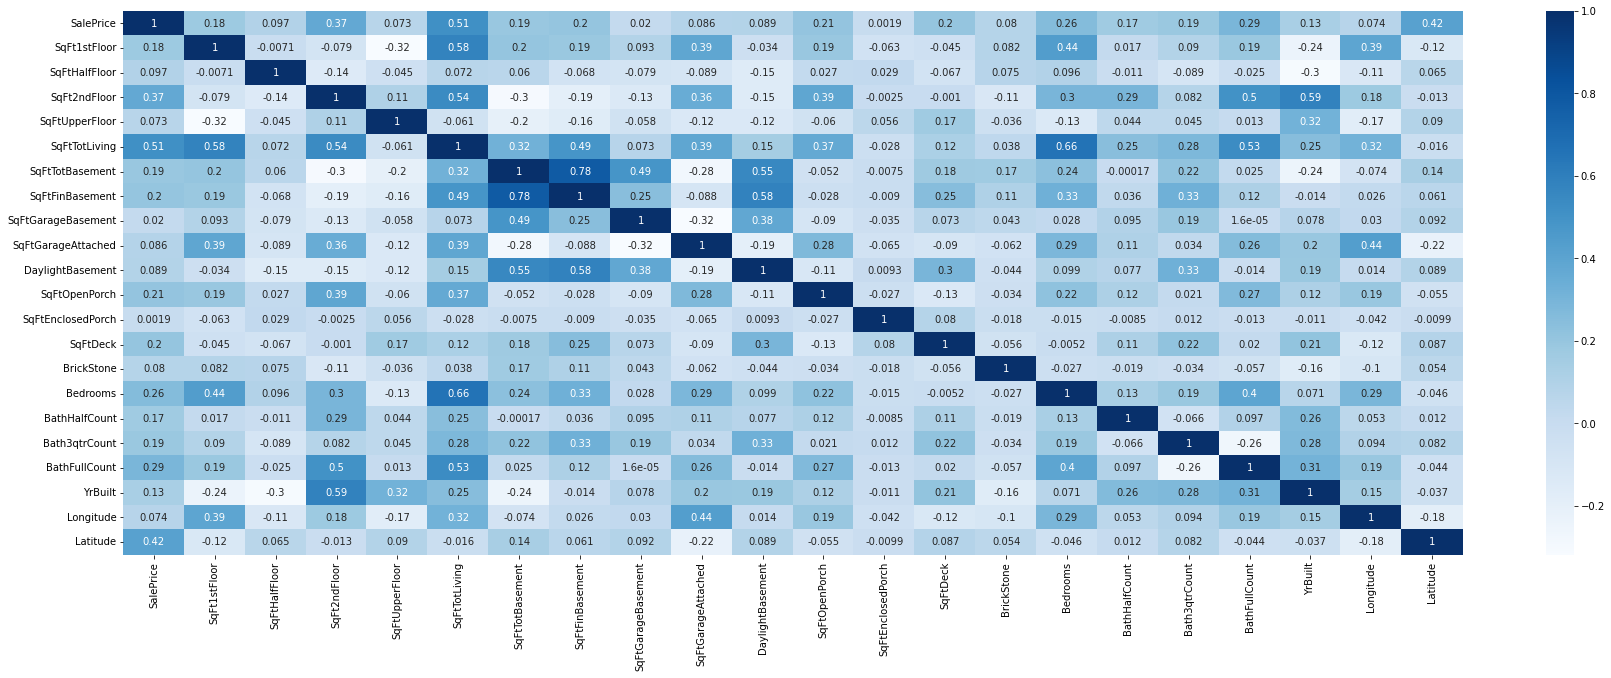

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))   
sns.heatmap(df.corr(),cmap='Blues',annot = True)

Based on the heatmap, SalePrice is most highly correlated with Total Sq Ft of living space. I will plot both along with 4 and 5 clusters to determine which K values is more appropriate.

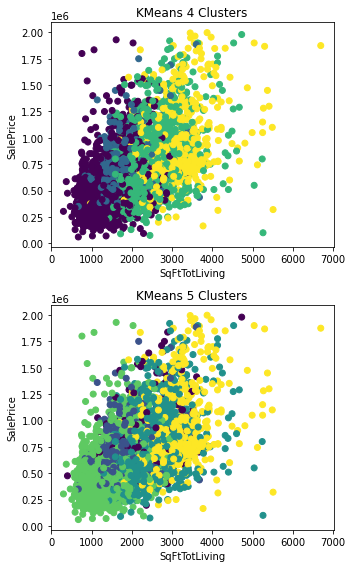

In [ ]:
# Save the cluster labels to the dataframe 
df['cluster4'] = km.labels_
df['cluster5'] = km2.labels_

# Visualize the clusters
fig, axes = plt.subplots(2,1, figsize=(5,8))
axes[0].scatter(df['SqFtTotLiving'], df['SalePrice'], c = df['cluster4'])
axes[0].set_xlabel('SqFtTotLiving')
axes[0].set_ylabel('SalePrice')
axes[0].set_title('KMeans 4 Clusters')
axes[1].scatter(df['SqFtTotLiving'], df['SalePrice'], c = df['cluster5'])
axes[1].set_xlabel('SqFtTotLiving')
axes[1].set_ylabel('SalePrice')
axes[1].set_title('KMeans 5 Clusters')
plt.tight_layout();

A K of 4 makes more sense, as the 5th cluster doesn't seem to add much value.

In [ ]:
#Recreate cluster column and drop unneeded cluster columns
df['cluster'] = km.labels_
df.drop(columns=['cluster4','cluster5'],inplace=True)

In [ ]:
# Use .groupby() to investigate the averages.
cluster_groups = df.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,0,535441.334704,1198.650386,95.829306,64.987147,0.000000,1440.407712,361.093573,84.719794,28.699229,155.235476,0.063239,41.640103,7.681234,66.243188,4.946015,3.019023,0.213882,0.283805,1.093059,1947.292545,-122.285139,47.557191
1,1,700563.034898,562.196149,6.309266,556.848375,148.950662,1537.246691,375.456077,266.551143,104.377858,10.611312,0.593261,25.819495,16.281588,299.560770,0.481348,2.753309,0.529483,0.903730,1.245487,2015.955475,-122.332683,47.615999
2,2,716037.064815,1418.153846,29.830484,70.339031,0.000000,2334.504274,1248.960826,816.558405,238.179487,135.510684,0.814815,40.233618,5.920940,203.675926,8.089031,3.804131,0.390313,0.945869,1.296296,1963.502849,-122.254255,47.581344
3,3,867099.687075,1368.091156,29.755102,1387.436735,8.965986,2946.763265,223.882993,154.715646,35.385034,461.043537,0.100680,154.240816,5.034014,90.700680,0.619048,4.229932,0.682993,0.614966,2.051701,2003.353741,-122.199998,47.545655


In [ ]:
# # Visualize means 
# fig, axes = plt.subplots(4,6, figsize = (40, 15))
# # fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
# axes = axes.ravel()
# # Loop over columns and plot each in a separate figure, skip 'cluster' column
# for i, col in enumerate(cluster_groups.columns[1:]):
#   axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
#   axes[i].set_title(f'Mean {col}')

From all the plots generated by the above code, handpicked a few for the final visual.

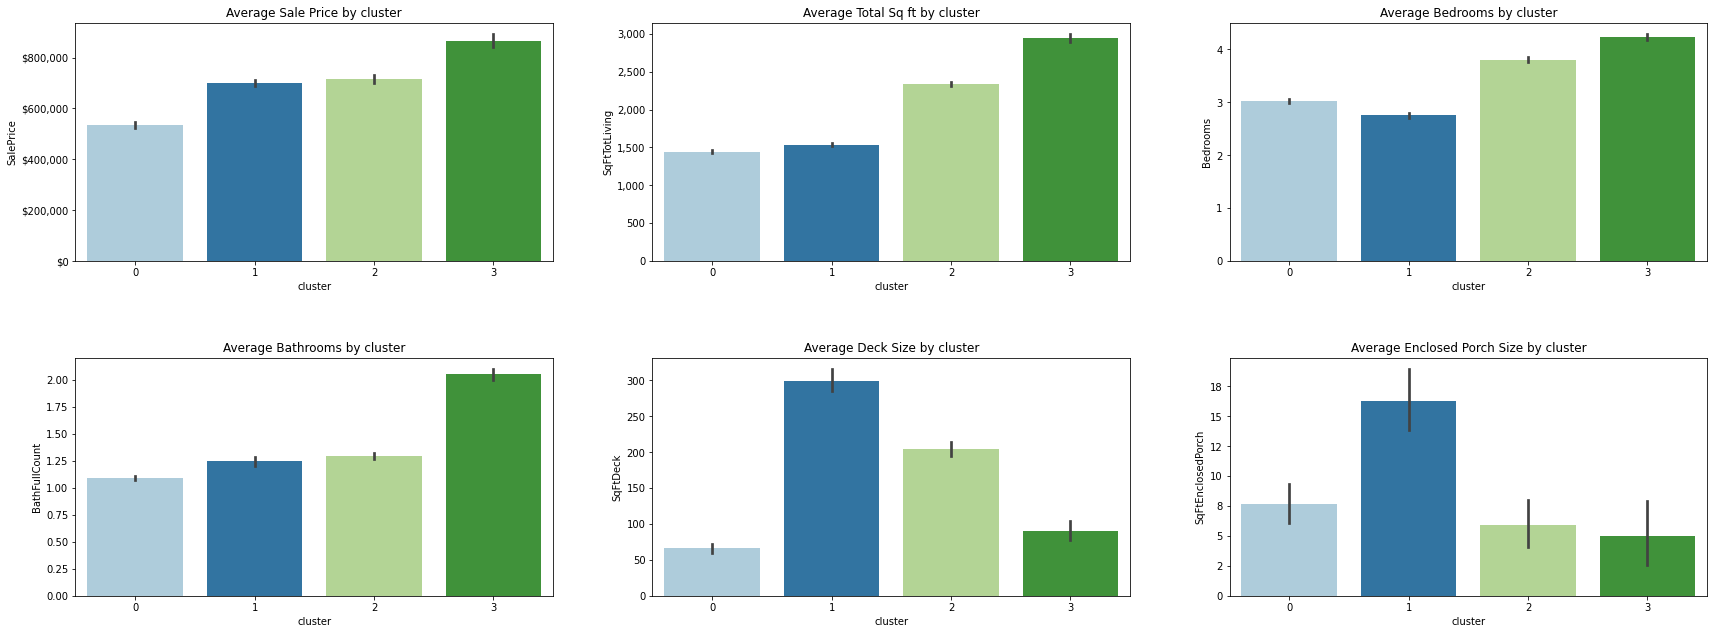

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (25, 10))

custom_palette = sns.color_palette("Paired", 4)
sns.set_palette(custom_palette)

sns.barplot(data=df,x='cluster',y='SalePrice',ax=ax[0][0]).set(title='Average Sale Price by cluster');
price_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax[0][0].yaxis.set_major_formatter(price_fmt)

sns.barplot(data=df,x='cluster',y='SqFtTotLiving',ax=ax[0][1]).set(title='Average Total Sq ft by cluster');
comma_fmt = mpl.ticker.StrMethodFormatter('{x:,.0f}')
ax[0][1].yaxis.set_major_formatter(comma_fmt)

sns.barplot(data=df,x='cluster',y='Bedrooms',ax=ax[0][2]).set(title='Average Bedrooms by cluster');
sns.barplot(data=df,x='cluster',y='BathFullCount',ax=ax[1][0]).set(title='Average Bathrooms by cluster');
sns.barplot(data=df,x='cluster',y='SqFtDeck',ax=ax[1][1]).set(title='Average Deck Size by cluster');
sns.barplot(data=df,x='cluster',y='SqFtEnclosedPorch',ax=ax[1][2]).set(title='Average Enclosed Porch Size by cluster');
ax[1][2].yaxis.set_major_formatter(comma_fmt)

fig.tight_layout(pad=5.0)



1) Cluster 3 has the highest average sale price, Clusters 1 and 2 are lower but similar to each other, and finally Cluster 0 has the lowest average sale price.


2) The typical metrics of Total Square feet, average bedrooms, and average bathrooms follow this same pattern seen in sale price.


3) One exception is Cluster 1 - these homes have a similar average Sale Price as Cluster 2 despite being smaller and having fewer bedrooms and bathrooms. By drilling down, I discovered that Cluster 1 has the largest deck and enclosed porches on average which helps explain the higher Sales Price.



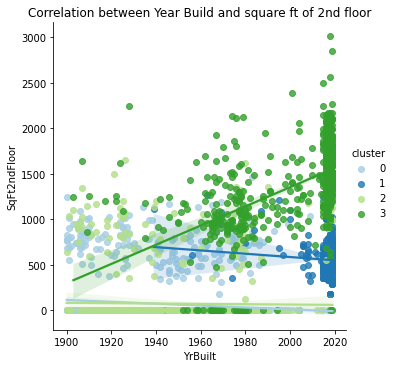

In [ ]:
custom_palette = sns.color_palette("Paired", 4)
sns.set_palette(custom_palette)
sns.lmplot(data=df,x='YrBuilt',y='SqFt2ndFloor',hue='cluster').set(title='Correlation between Year Build and square ft of 2nd floor');

1) Cluster 3 has the largest 2nd floors that are increasing with newer builds. Cluster 3 also comprises the majority of new homes with larger 2nd floors. 

2) On the other hand, the average size of the 2nd floor for Clusters 0-2 are similar and have not changed much over time.

3) Cluster 0 is distinguished in that Cluster 0 houses tend to be older.

4) Cluster 1 is unique in that most of these homes are newer builds with smaller 2nd floors than Cluster 3.

5) Cluster 2 is distinct in that it has the most homes with no 2nd floor as indicated by the 0 values.



In [ ]:
second_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/option_A_modeling_df - option_A_modeling_df.csv')
modeling_df = second_dataset.copy()
modeling_df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Longitude,Latitude,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store,BldgGrade_4,BldgGrade_5,BldgGrade_6,BldgGrade_7,BldgGrade_8,BldgGrade_9,BldgGrade_10,BldgGrade_11,BldgGrade_12,FinBasementGrade_3,FinBasementGrade_4,FinBasementGrade_5,FinBasementGrade_6,FinBasementGrade_7,FinBasementGrade_8,FinBasementGrade_9,FinBasementGrade_10,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,Condition_2,Condition_3,Condition_4,Condition_5,MonthSold_02,MonthSold_03,MonthSold_04,MonthSold_05,MonthSold_06,MonthSold_07,MonthSold_08,MonthSold_09,MonthSold_10,MonthSold_11,MonthSold_12,YearSold_2017,YearSold_2018,YearSold_2019,YearSold_2020
0,400000,1590,0,0,0,3180,1590,1590,0,600,1,50,0,220,0,6,0,2,1,1965,0,-122.196399,47.336118,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,474250,1390,0,0,0,2200,810,810,0,0,1,0,0,340,0,4,1,0,1,1945,0,-122.361913,47.509874,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2,667950,1010,0,1515,0,2525,0,0,0,400,0,167,0,0,0,4,1,0,2,2019,0,-122.156684,47.437557,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,659000,660,0,540,0,1820,620,620,0,0,1,0,0,100,0,3,1,0,2,2016,0,-122.370252,47.565146,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,656500,2310,0,0,0,2310,0,0,0,440,0,40,0,320,0,3,0,0,2,1967,0,-122.184194,47.730389,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

In [ ]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Columns: 171 entries, SalePrice to YearSold_2020
dtypes: float64(2), int64(169)
memory usage: 6.4 MB


In [ ]:
#No duplicate values
modeling_df.duplicated().sum()

0

In [ ]:
#No missing values
pd.set_option('display.max_rows', 200)
modeling_df.isna().sum().sort_values(ascending=False)

SalePrice                     0
Taco Place                    0
Chiropractor                  0
Bakery                        0
Mobile Phone Shop             0
Ice Cream Shop                0
Automotive Shop               0
Assisted Living               0
Health & Beauty Service       0
Fried Chicken Joint           0
Video Store                   0
BldgGrade_5                   0
Financial or Legal Service    0
Massage Studio                0
Asian Restaurant              0
Insurance Office              0
Japanese Restaurant           0
ATM                           0
Locksmith                     0
Shipping Store                0
Thai Restaurant               0
Pet Service                   0
Burger Joint                  0
General Travel                0
Furniture / Home Store        0
Bus Line                      0
Café                          0
Event Space                   0
Italian Restaurant            0
Marijuana Dispensary          0
Office                        0
Yoga Stu

In [ ]:
#All dtypes are numeric.
modeling_df.dtypes

SalePrice                       int64
SqFt1stFloor                    int64
SqFtHalfFloor                   int64
SqFt2ndFloor                    int64
SqFtUpperFloor                  int64
SqFtTotLiving                   int64
SqFtTotBasement                 int64
SqFtFinBasement                 int64
SqFtGarageBasement              int64
SqFtGarageAttached              int64
DaylightBasement                int64
SqFtOpenPorch                   int64
SqFtEnclosedPorch               int64
SqFtDeck                        int64
BrickStone                      int64
Bedrooms                        int64
BathHalfCount                   int64
Bath3qtrCount                   int64
BathFullCount                   int64
YrBuilt                         int64
PcntComplete                    int64
Longitude                     float64
Latitude                      float64
Golf Course                     int64
Other Great Outdoors            int64
Elementary School               int64
General Ente

In [ ]:
modeling_df.describe()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,PcntComplete,Longitude,Latitude,Golf Course,Other Great Outdoors,Elementary School,General Entertainment,Park,Mexican Restaurant,Vietnamese Restaurant,Gas Station,Housing Development,Playground,Pool,Church,Dive Bar,Convenience Store,Middle School,Grocery Store,Brewery,Bar,Salon / Barbershop,Post Office,Beach,Lake,Medical Center,Sandwich Place,Nail Salon,Pizza Place,Moving Target,Building,Preschool,Library,Trail,Farm,Community Center,High School,Gym / Fitness Center,Bridge,Gym,Supermarket,School,Dance Studio,Athletics & Sports,Garden,Airport,Beer Bar,Dog Run,Pharmacy,Scenic Lookout,Bank,Fast Food Restaurant,Miscellaneous Shop,Pet Store,Doctor's Office,Pub,Coffee Shop,Food Truck,Hardware Store,Bus Stop,Field,Laundry Service,Dentist's Office,Bus Station,Auto Dealership,Veterinarian,Tennis Court,Chinese Restaurant,Furniture / Home Store,Bus Line,Café,Event Space,Italian Restaurant,Marijuana Dispensary,Office,Yoga Studio,Restaurant,Baseball Field,Discount Store,Physical Therapist,American Restaurant,Martial Arts Dojo,Spa,Storage Facility,Daycare,General Travel,Burger Joint,Pet Service,Thai Restaurant,Chiropractor,Bakery,Mobile Phone Shop,Ice Cream Shop,Automotive Shop,Assisted Living,Health & Beauty Service,Fried Chicken Joint,Taco Place,Video Store,Financial or Legal Service,Massage Studio,Asian Restaurant,Insurance Office,Japanese Restaurant,ATM,Locksmith,Shipping Store,BldgGrade_4,BldgGrade_5,BldgGrade_6,BldgGrade_7,BldgGrade_8,BldgGrade_9,BldgGrade_10,BldgGrade_11,BldgGrade_12,FinBasementGrade_3,FinBasementGrade_4,FinBasementGrade_5,FinBasementGrade_6,FinBasementGrade_7,FinBasementGrade_8,FinBasementGrade_9,FinBasementGrade_10,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8,Condition_2,Condition_3,Condition_4,Condition_5,MonthSold_02,MonthSold_03,MonthSold_04,MonthSold_05,MonthSold_06,MonthSold_07,MonthSold_08,MonthSold_09,MonthSold_10,MonthSold_11,MonthSold_12,YearSold_2017,YearSold_2018,YearSold_2019,YearSold_2020
count,4.937000e+03,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.00000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4937.00

In [ ]:
X = modeling_df.drop(columns = 'SalePrice')
y = modeling_df['SalePrice']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [ ]:
X_train.shape

(3702, 170)

In [ ]:
#data processing/transforming pipeline
transformer = make_pipeline(StandardScaler(), PCA(n_components=0.9))
X_train_processed = transformer.fit_transform(X_train)
X_test_processed = transformer.transform(X_test)

In [ ]:
X_train_processed.shape

(3702, 129)

39/39 [==============================] - 0s 2ms/step
final RMSE: 203188.9796266055
final MAE: 141498.61595394736
final R2: 0.527600626268866


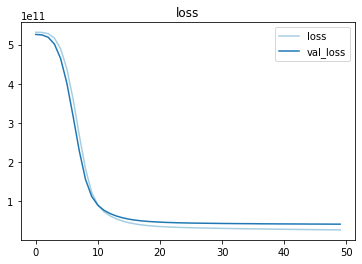

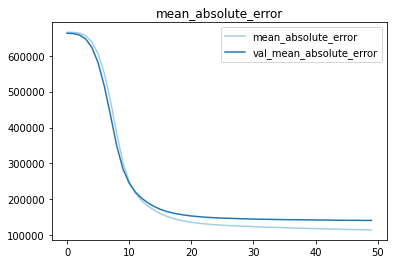

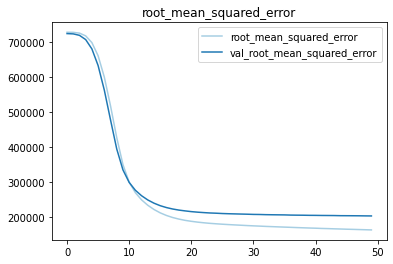

CPU times: user 20.5 s, sys: 1.31 s, total: 21.8 s
Wall time: 21.9 s


In [ ]:
#baseline deep learning model
%%time
 
base_model = Sequential()
 
base_model.add(Dense(50, input_dim=X_train_processed.shape[1], activation='relu'))
base_model.add(Dense(30, activation='relu'))
base_model.add(Dense(10, activation='relu'))
base_model.add(Dense(1, activation='linear'))
 
# compile model with additional metrics
base_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

base_history = base_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs=50,
                        verbose=0)

base_pred = base_model.predict(X_test_processed)

# output evaluation metrics/graphs 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, base_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, base_pred)}')
print(f'final R2: {r2_score(y_test, base_pred)}')

plot_history(base_history)

Baseline metrics show a bit of an issue with variance as the validation error is higher than the training error. The R2 score is also a bit low so we will try to add more complexity (additional layers/nodes) in the next iteration to increase R2 and decrease MAE/RMSE.

39/39 [==============================] - 0s 2ms/step
final RMSE: 196453.31273034515
final MAE: 137223.4769104251
final R2: 0.5584013596487905


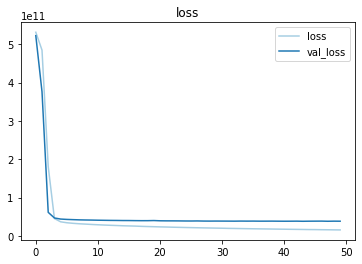

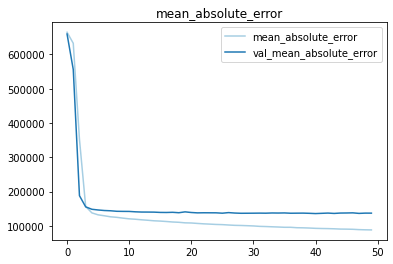

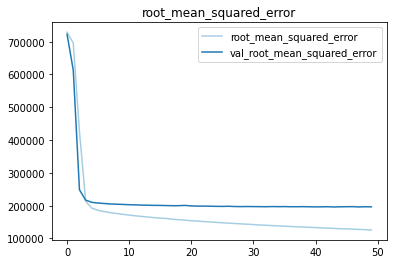

CPU times: user 24.8 s, sys: 1.43 s, total: 26.2 s
Wall time: 42.6 s


In [ ]:
#increase complexity to improve MAE/RMSE/R2
%%time
 
second_model = Sequential()

second_model.add(Dense(100, input_dim=X_train_processed.shape[1], activation='relu'))
second_model.add(Dense(80, activation='relu'))
second_model.add(Dense(40, activation='relu'))
second_model.add(Dense(15, activation='relu'))
second_model.add(Dense(1, activation='linear'))
 
# compile model with additional metrics
second_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

second_history = second_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs=50,
                        verbose=0)

second_pred = second_model.predict(X_test_processed)

# output evaluation metrics/graphs 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, second_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, second_pred)}')
print(f'final R2: {r2_score(y_test, second_pred)}')

plot_history(second_history)

After adding more layers/nodes, the RMSE, MAE, and R2 all improved slightly. However, variance has increased - the gap between the training and validation lines has grown. In our next iteration we will add dropout to reduce variance.

39/39 [==============================] - 0s 2ms/step
final RMSE: 200763.50697288525
final MAE: 139448.00961538462
final R2: 0.5388114024656161


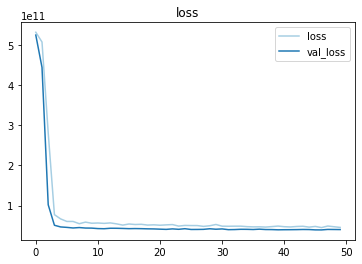

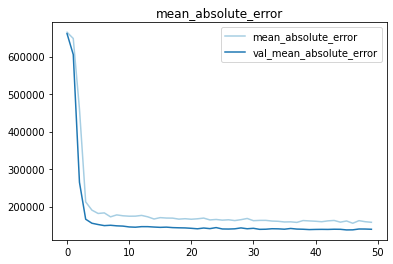

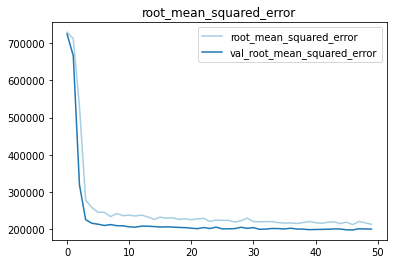

CPU times: user 25.4 s, sys: 1.43 s, total: 26.8 s
Wall time: 22.2 s


In [ ]:
#add dropout to reduce variance
%%time
 
third_model = Sequential()
 
third_model.add(Dense(100, input_dim=X_train_processed.shape[1], activation='relu'))
third_model.add(Dropout(.4))
third_model.add(Dense(80, activation='relu'))
third_model.add(Dropout(.2))
third_model.add(Dense(40, activation='relu'))
third_model.add(Dropout(.2))
third_model.add(Dense(15, activation='relu'))
third_model.add(Dropout(.1))
third_model.add(Dense(1, activation='linear'))
 
# compile model with additional metrics
third_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

third_history = third_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs=50,
                        verbose=0)

third_pred = third_model.predict(X_test_processed)

# output evaluation metrics/graphs 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, third_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, third_pred)}')
print(f'final R2: {r2_score(y_test, third_pred)}')

plot_history(third_history)

The addition of dropout has addressed the variance issue as the validation error lines are now below the training lines. This was accomplished while keeping MAE, RMSE, and R2 at a similar level as the second model. For these reasons, I would choose this 3rd model as my final model.

<br>

One advantage of MAE and RMSE is that they are in the same units as the target (Sale Price). In particular, the MAE for my chosen model is `$`138K. As the average house price in the dataset is $664K, this means my chosen model will be off by 20% on average.


In [ ]:
modeling_df['SalePrice'].mean()

664496.9244480453

In [ ]:
modeling_df['SalePrice'].median()

630800.0